# Problema 9.2

Determinar los parámetros efectivos de un sistema a partir de la curva de reacción que se indica y calcular la frecuencia crítica y la ganancia máxima. Determinar los ajustes de los parámetros de un controlador PID según el método de Ziegler-Nichols y compararlos con los que se obtienen directamente de la curva de reacción.

Tiempo (min) | Resp. (ua)
-------------|-----------
0 | 0
1 | 0
2 | 0
3 | 4
4 | 10
5 | 19
6 | 27
7 | 35
8 | 41
9 | 45
30 | 50

---

**Solución**

A partir de los datos de la curva de reacción se pueden obtener los parámetros de la función de transferencia de lazo abierto de varias maneras. En vualquier caso se supone que la curva de reacción del proceso sigue un modelo de primer orden con retraso.

_Determinación de los parámetros de la curva de respuesta del proceso_

Se representan los puntos disponibles y se encuentran en el gráfico los puntos $B$, $\tau$ y $t_d$, tal como se muestra en la figura a continuación:

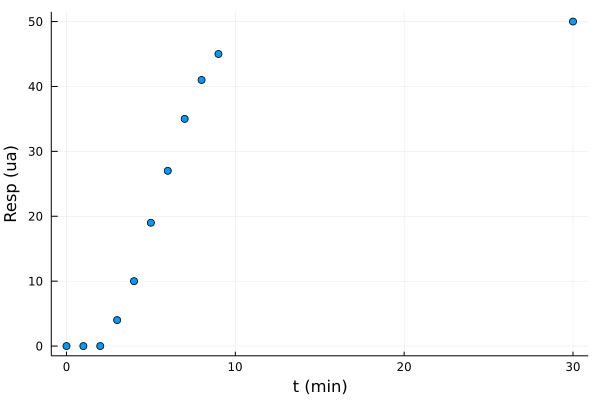

In [1]:
include("../clase.jl")

t = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 30]
Resp = [0, 0, 0, 4, 10, 19, 27, 35, 41, 45, 50]

scatter(t, Resp, legend=false, xlabel="t (min)",
    ylabel="Resp (ua)")

A partir del gráfico se observa que $B$ toma un valor de 50 ua. Suponiendo que se haya realizado una entrada en forma de escalón unidad ($A=1$), se puede obtener directamente el valor de la ganancia del proceso ($K_p=\frac{B}{A}$):

In [2]:
Kp = 50

50

Para encontrar el retraso, determinamos cuando empeiza a responder el proceso, tal como muestra la {numref}`CRP_fig`. Para ellos, hemos considerado la recta que pasa entre los puntos (4 min, 10 ua) y (6 min, 27 ua):

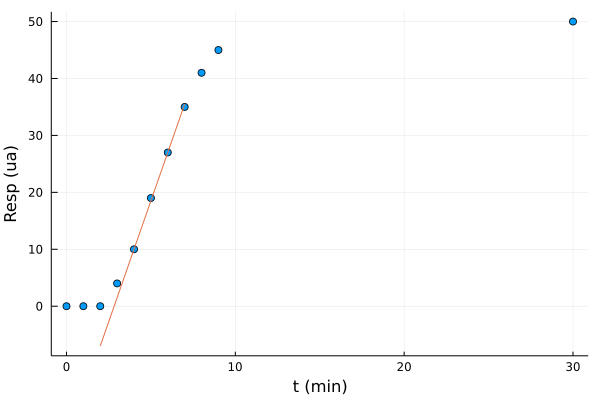

In [3]:
# Cálculo de la pendiente (a) y de la ordenada en el origen (b)
a = (27-10)/(6-4)
b = 27 - a*6

# Representación de la recta
plot!(t->a*t+b, 2.0, 7.0)

Como consecuencia el valor del retraso será el tiempo que hace que esa recta tenga un valor $Resp = 0$:

In [4]:
td = -b/a 

2.823529411764706

Para determinar la constante de tiempo del proceso ($\tau_p$), deberemos encontrar el tiempo para el que la $Resp$ es $B*(1-1/\mathrm{e})$). El tiempo que encontraremos será $\tau_p + t_d$, por lo que será necesario restar el valor del retraso que hemos encontrado más arriba:

In [5]:
# Utilizaremos un algoritmo de interpolación lineal para encontrar el
# tiempo que hace que Rep = B*(1-exp(-1))
itp = LinearInterpolation(t, Resp);

# Resolvemos la ecuación numéricamente
Tp = find_zero(t->itp(t)-50*(1-exp(-1)), 8)-td

3.7522240809137792

Comprobamos la bondad del ajuste representando la respuesta del proceso de primer orden con un retraso utilizando los valores obtenidos a partir de la curva de respuesta del proceso:

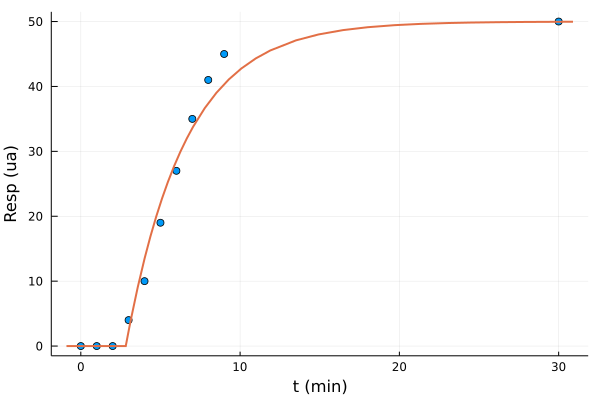

In [6]:
R(t) = Kp*(1-exp(-(t-td)/Tp))*(t>td)

scatter(t, Resp, legend=false, xlabel="t (min)",
    ylabel="Resp (ua)")
plot!(R, lw=2)

Se comprueba que se obtiene un ajuste razonable considerando la simplicidad del método utilizado. La razón más probable por la que el ajuste no es mejor es porque no se trate realmente de un proceso de primer orden. Probablemente un proceso de segundo orden sobreamortiguado con un retraso proporcionaría mejor ajuste.

_Sintonía con el método de Cohen y Coon_

Para encontrar la sintonía por el método de lazo abierto o de la curva de respuesta del proceso, solo hay que sustituir en las fórmulas propias de un controlador PID:

In [7]:
Kc_cc = 1/Kp*Tp/td*(4/3+td/4/Tp)

0.040437671875296795

In [8]:
Ti_cc = td*(32+6*td/Tp)/(13+8*td/Tp)

5.420678851042273

In [9]:
Td_cc = td*4/(11+2*td/Tp)

0.9031688839998492

_Sintonía por el método de Ziegler y Nichols_

Para aplicar este método deberemos encontrar el periodo último de oscilación y la ganancia última considerando un controlador proporcional.

Obtendremos estos valores considerando la siguiente función de transferencia de lazo abierto:

$$G_{OL} = K_c G_{CRP}$$

Al dibujar el diagrama de Bode, representaremos $\frac{RA}{K_c}$, lo que permitirá encontrar el parámetro $M$, a partir del que calcularemos la ganancia última $K_u$. El valor de $P_u$ lo calcularemos a partir de la frecuencia de cruce:

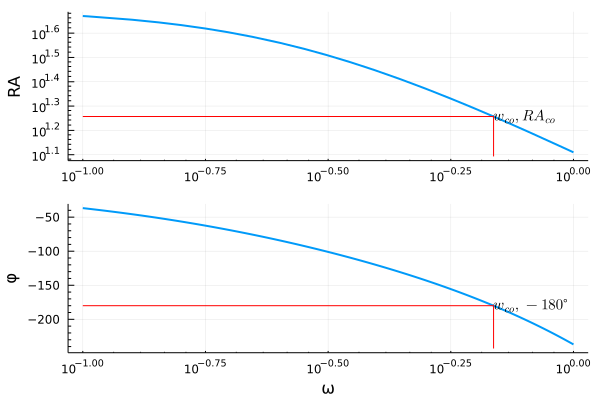

In [10]:
salida = bode(Kp/(Tp*s+1)*exp(-td*s); wmax=1, co=true);

Por lo tanto:

In [11]:
wco = salida["wco"]

0.6873341673074302

In [12]:
M = salida["RAco"]

18.0758782021065

Lo que supone:

In [13]:
Ku = 1/M

0.0553223466555259

In [14]:
Pu = 2*pi/wco

9.141383632641746

La sintonía del controlador será:

In [15]:
Kc_zn = Ku/1.7

0.0325425568561917

In [16]:
Ti_zn = Pu/2

4.570691816320873

In [17]:
Td_zn = Pu/8

1.1426729540802183

_Comparativa de las dos sintonías_

Estas son las sintonías obtenidas:

 | |Cohen-Coon | Ziegler-Nichols
 -|-----------|----------------
 $K_c$ | 0.040 | 0.032
 $\tau_I$ | 4.4 | 4.6
 $\tau_d$ | 0.90 | 1.1
 
 Como se puede observar la sintonía obtenida por el método de Cohen y Coon es más agresiva, tiene una mayor ganancia proporcional y una menor constante de tiempo integral. Por otro lado, la acción de control derivativa de la sintonía propuesta por el método de Ziegler y Nichols es más elevada.
 
 Para comparar el rendimiento de ambas sintonías se puede realizar una cambio en la consigna en forma de escalón unidad:

In [18]:
Gcrp = Kp/(Tp*s+1)*exp(-td*s)

# Sintonía de Cohen-Coon
Gc_cc = Kc_cc*(1+1/(Ti_cc*s)+Td_cc*s)
G_cc = Gc_cc*Gcrp/(1+Gc_cc*Gcrp)

# Sintonía de Ziegler-Nichols

Gc_zn = Kc_zn*(1+1/(Ti_zn*s)+Td_zn*s)
G_zn = Gc_zn*Gcrp/(1+Gc_zn*Gcrp)

                  ⎛                                            0.0071198317812
               50⋅⎜0.0371854995761881⋅s + 0.0325425568561917 + ───────────────
                  ⎝                                                     s     
──────────────────────────────────────────────────────────────────────────────
⎛       ⎛                                            0.00711983178126118⎞  -2.
⎜    50⋅⎜0.0371854995761881⋅s + 0.0325425568561917 + ───────────────────⎟⋅ℯ   
⎜       ⎝                                                     s         ⎠     
⎜1 + ─────────────────────────────────────────────────────────────────────────
⎝                                      3.75222408091378⋅s + 1                 

6118⎞  -2.82352941176471⋅s                
────⎟⋅ℯ                                   
    ⎠                                     
──────────────────────────────────────────
82352941176471⋅s⎞                         
                ⎟                         
                ⎟             

En este caso la transformada invesa de Laplace no parece tener solución analítica, por lo que la realizaremos numéricamente utilizando el [método de Talbot](https://academic.oup.com/imamat/article-abstract/23/1/97/786127):

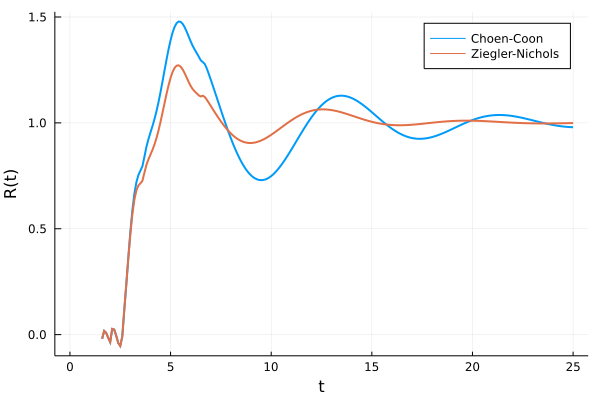

In [19]:
using InverseLaplace

# Constructores de las transformadas inversas de Laplace
y_cc = ILT(lambdify(G_cc*1/s))
y_zn = ILT(lambdify(G_zn*1/s))

# Valores de tiempo para los que haremos la simulación
tt = range(0, 25, step=0.1)

# Cálculo de las respuesta de los lazos de control
y_cc_t = map(y_cc, tt)
y_zn_t = map(y_zn, tt)

# Representación de las simulaciones realizadas
plot(tt, y_cc_t, label="Choen-Coon", xlabel="t", ylabel="R(t)", lw=2)
plot!(tt, y_zn_t, label="Ziegler-Nichols", lw=2)

Se puede comprobar que la sintonía de Cohen-Coon tiene una respuesta ligeramente más rápida (tiempo necesario en alcanzar el valor estacionario por primera vez). Pero tiene como inconvenientes un mayor _overshoot_ y una respuesta más subamortiguada.